Load all necessary imports

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import h5py

# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-03-06 17:03:46.350188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21969 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Data Loading

In [105]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)

Data Normalization

In [106]:
image_normalized = (images+1)/9.26 # Normalize images and add noise


# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]

In [107]:
from tensorflow.keras import layers, models



input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 4

images_np = image_normalized
#images_np = tf.expand_dims(images_np, axis=-1)
probabilities = np.array(normalized_boxes[:, :,:-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

dataset = dataset.batch(250)
dataset = dataset.shuffle(buffer_size=500, reshuffle_each_iteration=True) 

x_input = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=4, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 

x = layers.Conv2D(64, kernel_size=4, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  

x = layers.Conv2D(128, kernel_size=4, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(128, kernel_size=4, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(256, kernel_size=4, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(256, kernel_size=4, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(512, kernel_size=4, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(512, kernel_size=4, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(256, kernel_size=4, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x


x = layers.Flatten()(x)
# Bounding box output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Consider adjusting based on performance





model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'] )
num_epochs = 3000
model.fit(dataset, epochs=num_epochs)

Epoch 1/3000
40/40 [==============================] - 17s 324ms/step - loss: 0.7520 - x_prob_reshape_loss: 0.5961 - x_boxes_reshape_loss: 0.1560 - x_prob_reshape_accuracy: 0.6988 - x_boxes_reshape_accuracy: 0.2568
Epoch 2/3000
40/40 [==============================] - 13s 333ms/step - loss: 0.5292 - x_prob_reshape_loss: 0.4411 - x_boxes_reshape_loss: 0.0881 - x_prob_reshape_accuracy: 0.7883 - x_boxes_reshape_accuracy: 0.2563
Epoch 3/3000
40/40 [==============================] - 13s 332ms/step - loss: 0.5311 - x_prob_reshape_loss: 0.4446 - x_boxes_reshape_loss: 0.0865 - x_prob_reshape_accuracy: 0.7843 - x_boxes_reshape_accuracy: 0.2531
Epoch 4/3000
40/40 [==============================] - 14s 338ms/step - loss: 0.4482 - x_prob_reshape_loss: 0.3702 - x_boxes_reshape_loss: 0.0780 - x_prob_reshape_accuracy: 0.8303 - x_boxes_reshape_accuracy: 0.2549
Epoch 5/3000
40/40 [==============================] - 14s 337ms/step - loss: 0.3977 - x_prob_reshape_loss: 0.3239 - x_boxes_reshape_loss: 0.0738

In [126]:
model.save('model5zeroes.h5')

/home/m3-learning/anaconda3/envs/electron/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [109]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.batch(500)
inputs,targets = next(iter(dataset))
output = model.predict(inputs)

16/16 [==============================] - 0s 17ms/step


In [103]:
targets['x_boxes_reshape'][0,10] ,output[1][10]

2024-03-06 16:36:59.332175: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 10 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 10 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [113]:
import tensorflow as tf

r = np.random.randint(0,500)
tensor1 = tf.constant(targets['x_boxes_reshape'][r], dtype=tf.float64)

tensor2 = tf.constant(output[1][r], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 0.029991835717309366


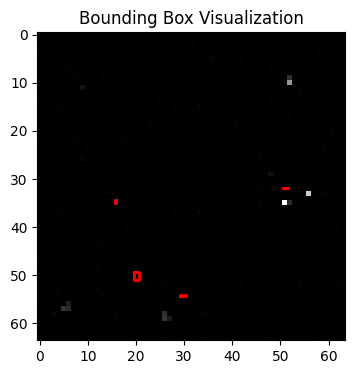

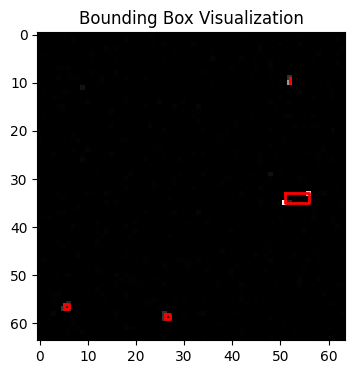

In [138]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.5):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,500)
# probabilities = tf.convert_to_tensor(output[0][t,:])

visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction
